In [1]:
import os
import pandas as pd
import csv
import numpy as np
import time

from datetime import datetime

predicted_data_path = "/home/aayush/accelerometer/accprocess/results"
annotated_data_path = "/home/yacine/accel/capture24/participants/"
aggregated = "/home/aayush/accelerometer/accprocess/data_saved/PA3/combined"

labels_dict_location = "/home/aayush/accelerometer/accprocess/anno-label.csv"

In [2]:
def get_files(data_path, predicted_files=False, annotated_files=False) -> None:
    total_csv_zipped = []
    for path, dirnames, filenames in os.walk(data_path):

        for file in filenames:
            if file.endswith(".csv.gz") and predicted_files:
                # paths contains the base directory for that file.
                # dirnames contains other directories within this folder.
                # filenames contains the list of filenames within path.
                total_csv_zipped.append(os.path.join(path, file))
                
            if file.endswith(".csv") and annotated_files and file[0]!='c': #ignore the capture24 file
                # paths contains the base directory for that file.
                # dirnames contains other directories within this folder.
                # filenames contains the list of filenames within path.
                total_csv_zipped.append(os.path.join(path, file))

    return sorted(total_csv_zipped)

In [3]:
def create_labels_dict():
    labels_dict = {}
    with open(labels_dict_location, "r") as annotation_dict:
        reader = csv.DictReader(annotation_dict)
        for row in reader:
            if labels_dict.get(row['annotation']) is None:
                labels_dict[row['annotation']] = [row['label:Walmsley2020']]
            else:
                labels_dict[row['annotation']].append(row['label:Walmsley2020'])
    return labels_dict


def parse_datetime(dt_string):
    clean_datetime_str = dt_string.split('[')[0].strip()
    dt_object = pd.to_datetime(clean_datetime_str)
    return dt_object


def parse_datetime_df_time(dt_string):
    clean_datetime_str = dt_string.split('[')[0].strip()
    clean_datetime_str = clean_datetime_str.split('+')[0].strip()
    dt_object = pd.to_datetime(clean_datetime_str)
    return dt_object

In [4]:
predicted_data_files = get_files(data_path=predicted_data_path, predicted_files=True)
annotated_data_files = get_files(data_path=annotated_data_path, annotated_files=True)
aggregated_files = get_files(data_path=aggregated, annotated_files=True)
assert len(predicted_data_files) == len(annotated_data_files), "Number of predicted and annotated data files should be the same."
assert len(aggregated_files) == len(predicted_data_files), "Number of predicted and aggregated should be the same."

labels_dict = create_labels_dict()

labels = ["light", "moderate-vigorous", "sedentary", "sleep"]

In [5]:
cp_labels_dict = {'CpSB': ["sedentary"], 'CpLPA': ["light"], 'CpMVPA': ["moderate-vigorous"]}


In [6]:
def decode_activities(data_file):
    df = pd.read_csv(data_file)
    
    # retrieve only the activities headers
    activities = df[df.columns.values.tolist()[2:6]]
    
    # whichever activity is depicted by 1, use it as the predicted activity
    df["activity_predicted_walmsley"] = activities[activities==1].idxmax(axis=1)
    
    df.loc[df["acc"]<50, "CpSB"] = 1.0    
    # retrieve only the cp columns - cp_cols = df.columns.values.tolist()[6:8]
    cp_cols = df.columns.values.tolist()[6:8]
    cp_cols.append(df.columns.values.tolist()[10])
    activities = df[cp_cols]    
    df["activity_predicted_cp"] = activities[activities==1].idxmax(axis=1)
    
    return df
    
    
def process_annotated_data(annotated_data_file):
    annotated_data = pd.read_csv(annotated_data_file)
    # Take the timestamp after every thirty seconds
    actual_labels = annotated_data[["annotation", "time"]][0::3000]
    
    # Convert to datetime object
    actual_time = actual_labels["time"].apply(parse_datetime)
    actual_labels["time"] = actual_time
    
    return actual_labels
    


def filtering_data(df, actual_labels, labels_dict, predicted_id):
    
    # Convert to datetime object
    df['time_cleaned'] = df['time'].apply(parse_datetime_df_time)
    df["participant_id"] = predicted_id
    
    # # drop all 'nan' rows from actual labels
    # actual_labels = actual_labels.dropna(subset=['annotation'])
    
    # replace the annotated labels with the same format of strings as predicted labels using mapping from labels_dict
    flat_dict = {k: v[0] for k, v in labels_dict.items()}
    actual_labels['annotation'].replace(flat_dict, inplace=True)
    
    
    flat_dict = {k: v[0] for k, v in cp_labels_dict.items()}
    df['activity_predicted_cp'].replace(flat_dict, inplace=True)  
    
    return actual_labels, df

In [7]:
df_final_all = []

for predicted_file, annotated_file in zip(sorted(predicted_data_files)[0:5], sorted(annotated_data_files)[0:5]):
    predicted_id = int(predicted_file.split("/")[-1].split("-")[0][1:])
    annotated_id = int(annotated_file.split("/")[-1].split(".")[0][1:])
    assert predicted_id == annotated_id, "Participant ID for annotated and predicted should be same"

    print(predicted_id)
    aggregated_file = os.path.sep.join(aggregated_files[0].split("/")[:-1] + [f"{predicted_id}.csv"])
    print(predicted_file)
    print(annotated_file)
    print(aggregated_file)
    agg = pd.read_csv(aggregated_file)
    agg["time"] = pd.to_datetime(agg["time"])
 
    df = decode_activities(predicted_file)
    actual_labels = process_annotated_data(annotated_file)

    actual_labels, df = filtering_data(df, actual_labels, labels_dict, predicted_id)
    
    df["time"] = df["time_cleaned"]
 
    # first merge PA12 and PA3.
    PA123 = df.merge(agg, how="inner", on="time", suffixes=("_x", "_PA3"))
    
    final = PA123.merge(actual_labels, how="inner", on="time")
    final = final.drop(columns=["time_cleaned"])
    
    
    final.to_csv(os.path.join("/home/aayush/accelerometer/accprocess/data_saved/PA123", f"{predicted_id}.csv"), index=False)
    df_final_all.append(final)
    
    print("##############DONE#############")

1
/home/aayush/accelerometer/accprocess/results/P001-timeSeries.csv.gz
/home/yacine/accel/capture24/participants/P001.csv
/home/aayush/accelerometer/accprocess/data_saved/PA3/combined/1.csv


/tmp/ipykernel_3168172/1515028304.py:17: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  actual_labels = process_annotated_data(annotated_file)


##############DONE#############
2
/home/aayush/accelerometer/accprocess/results/P002-timeSeries.csv.gz
/home/yacine/accel/capture24/participants/P002.csv
/home/aayush/accelerometer/accprocess/data_saved/PA3/combined/2.csv
##############DONE#############
3
/home/aayush/accelerometer/accprocess/results/P003-timeSeries.csv.gz
/home/yacine/accel/capture24/participants/P003.csv
/home/aayush/accelerometer/accprocess/data_saved/PA3/combined/3.csv
##############DONE#############
4
/home/aayush/accelerometer/accprocess/results/P004-timeSeries.csv.gz
/home/yacine/accel/capture24/participants/P004.csv
/home/aayush/accelerometer/accprocess/data_saved/PA3/combined/4.csv
##############DONE#############
5
/home/aayush/accelerometer/accprocess/results/P005-timeSeries.csv.gz
/home/yacine/accel/capture24/participants/P005.csv
/home/aayush/accelerometer/accprocess/data_saved/PA3/combined/5.csv
##############DONE#############


In [17]:
df_final_all_pd = pd.concat(df_final_all, ignore_index=True, axis=0)


In [18]:
def categorize_activity(axis1_value):
    if axis1_value < 2860/2:
        return 'sedentary'
    elif 2860/2 <= axis1_value <= 3940/2:
        return 'light'
    elif axis1_value >= 3941/2:
        return 'moderate-vigorous'
    else:
        return 'NaN'  # In case there's an unexpected value


# Apply the function to categorize each row based on axis1 values
df_final_all_pd['PA3'] = df_final_all_pd['axis1'].apply(categorize_activity)


In [19]:
df_final_all_pd

,time,acc,light,moderate-vigorous,sedentary,sleep,CpSB,CpLPA,CpMPA,CpVPA,...,MET,activity_predicted_walmsley,activity_predicted_cp,participant_id,annotation_x,axis1,axis2,axis3,annotation_y,PA3
0,2016-11-13 02:18:00,0.767,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,1,sleep,22.0,27.0,31.0,sleep,sedentary
1,2016-11-13 02:18:30,0.819,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,1,sleep,0.0,0.0,0.0,sleep,sedentary
2,2016-11-13 02:19:00,1.226,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,1,sleep,0.0,0.0,0.0,sleep,sedentary
3,2016-11-13 02:19:30,1.292,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,1,sleep,0.0,0.0,0.0,sleep,sedentary
4,2016-11-13 02:20:00,1.213,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,1,sleep,0.0,0.0,0.0,sleep,sedentary
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15292,2016-02-09 03:54:30,9.851,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,5,sleep,0.0,0.0,0.0,sleep,sedentary
15293,2016-02-09 03:55:00,9.609,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,5,sleep,0.0,0.0,0.0,sleep,sedentary
15294,2016-02-09 03:55:30,10.430,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,5,sleep,0.0,0.0,0.0,sleep,sedentary
15295,2016-02-09 03:56:00,10.297,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.95,sleep,sedentary,5,sleep,0.0,0.0,0.0,sleep,sedentary


In [22]:
df = df_final_all_pd[["activity_predicted_walmsley", "activity_predicted_cp", "participant_id", "annotation_x", "PA3", "time"]]
# df[df["annotation_x"] != df["annotation_y"]]
print(len(df))
df = df.dropna()
print(len(df))

15297
10148


In [23]:
df

,activity_predicted_walmsley,activity_predicted_cp,participant_id,annotation_x,PA3,time
0,sleep,sedentary,1,sleep,sedentary,2016-11-13 02:18:00
1,sleep,sedentary,1,sleep,sedentary,2016-11-13 02:18:30
2,sleep,sedentary,1,sleep,sedentary,2016-11-13 02:19:00
3,sleep,sedentary,1,sleep,sedentary,2016-11-13 02:19:30
4,sleep,sedentary,1,sleep,sedentary,2016-11-13 02:20:00
...,...,...,...,...,...,...
15292,sleep,sedentary,5,sleep,sedentary,2016-02-09 03:54:30
15293,sleep,sedentary,5,sleep,sedentary,2016-02-09 03:55:00
15294,sleep,sedentary,5,sleep,sedentary,2016-02-09 03:55:30
15295,sleep,sedentary,5,sleep,sedentary,2016-02-09 03:56:00


In [24]:
cp_proportions = df.groupby("participant_id", group_keys=True)["activity_predicted_cp"].value_counts(normalize=True).unstack()
walmsley_proportions = df.groupby("participant_id", group_keys=True)["annotation_x"].value_counts(normalize=True).unstack()
annotation_proportions = df.groupby("participant_id", group_keys=True)["activity_predicted_walmsley"].value_counts(normalize=True).unstack()
PA3_proportions = df.groupby("participant_id", group_keys=True)["PA3"].value_counts(normalize=True).unstack()

In [28]:
# Reindex the dataframes to have consistent columns
all_columns = sorted(set(cp_proportions.columns) | set(walmsley_proportions.columns) | set(annotation_proportions.columns))

cp_proportions = cp_proportions.reindex(columns=all_columns, fill_value=0)
walmsley_proportions = walmsley_proportions.reindex(columns=all_columns, fill_value=0)
annotation_proportions = annotation_proportions.reindex(columns=all_columns, fill_value=0)
PA3_proportions = PA3_proportions.reindex(columns=all_columns, fill_value=0)

# # keep only first 20
# cp_proportions = cp_proportions.head(20)
# walmsley_proportions = walmsley_proportions.head(20)
# annotation_proportions = annotation_proportions.head(20)



In [29]:
PA3_proportions

PA3,light,moderate-vigorous,sedentary,sleep
participant_id,,,,
1,0.072218,0.080289,0.847494,0
2,0.077361,0.094425,0.828214,0
3,0.099495,0.113636,0.786869,0
4,0.025093,0.011212,0.963695,0
5,0.065964,0.055886,0.878149,0


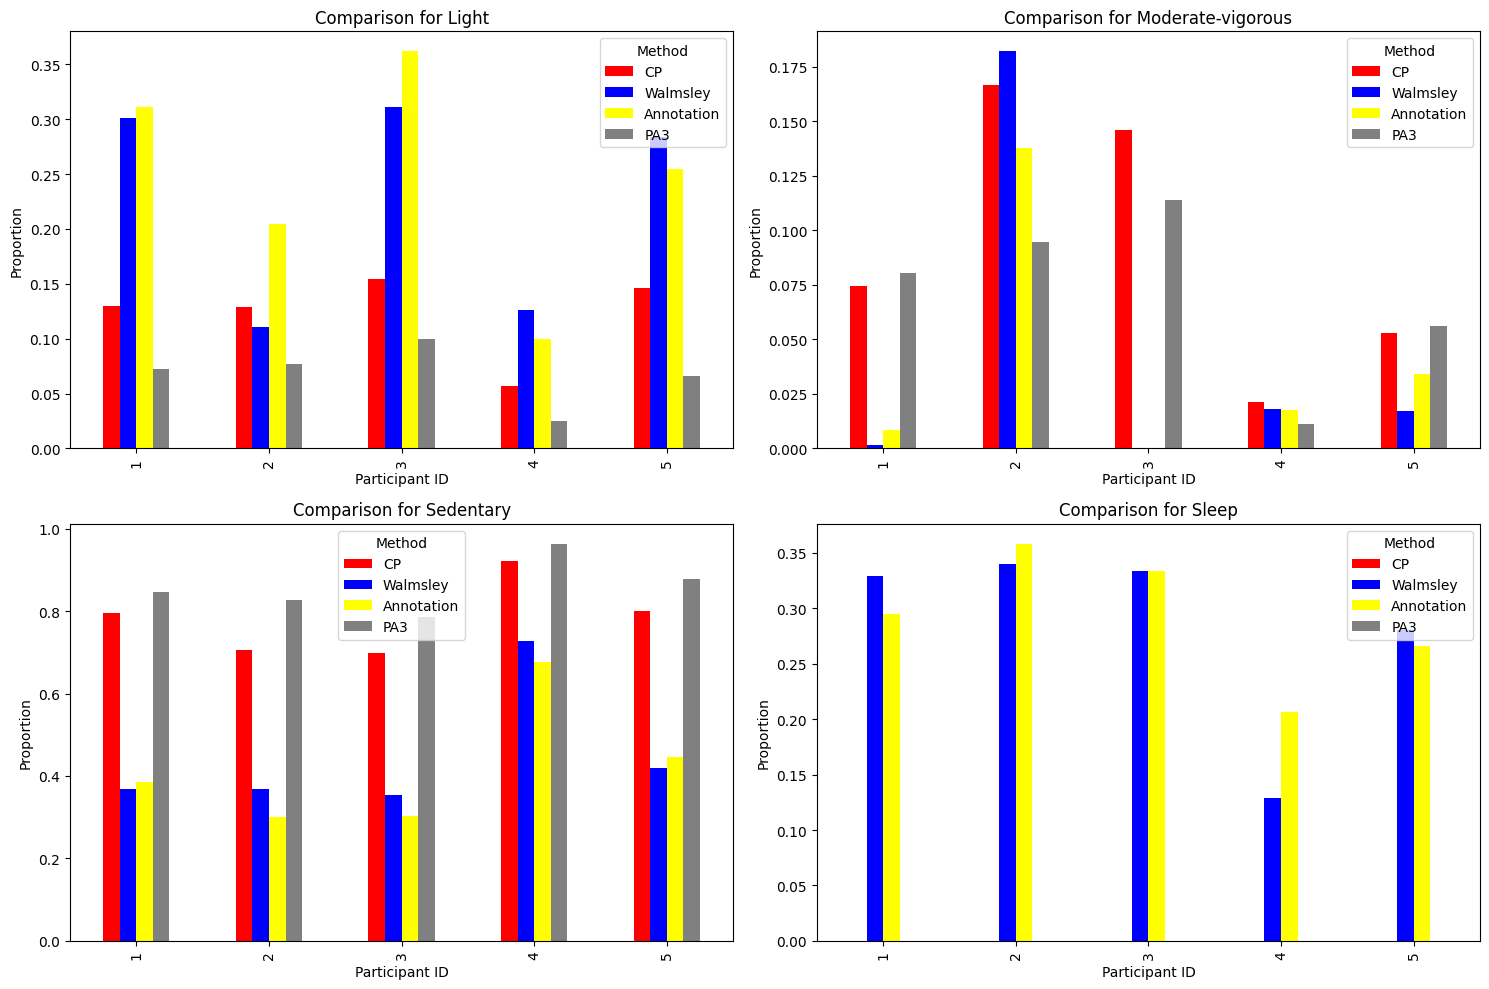

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# already set
# cp_proportions = cp_proportions.set_index("participant_id")
# walmsley_proportions = walmsley_proportions.set_index("participant_id")
# annotation_proportions = annotation_proportions.set_index("participant_id")

# List of classifications
classifications = ["light", "moderate-vigorous", "sedentary", "sleep"]

# Plotting the bar graphs
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
colors = ['red', 'blue', 'yellow', 'grey'] 
for i, classification in enumerate(classifications):
    ax = axs[i//2, i%2]
    
    cp_data = cp_proportions[classification] if classification in cp_proportions.columns else [0] * len(cp_proportions)
    walmsley_data = walmsley_proportions[classification] if classification in walmsley_proportions.columns else [0] * len(walmsley_proportions)
    annotation_data = annotation_proportions[classification] if classification in annotation_proportions.columns else [0] * len(annotation_proportions)
    PA3_data = PA3_proportions[classification] if classification in PA3_proportions.columns else [0] * len(PA3_proportions)
    
    df = pd.DataFrame({
        "CP": cp_data,
        "Walmsley": walmsley_data,
        "Annotation": annotation_data,
        "PA3": PA3_data
    }, index=cp_proportions.index)
    
    df.plot(kind='bar', ax=ax, title=f'Comparison for {classification.capitalize()}', color=colors)
    ax.set_xlabel("Participant ID")
    ax.set_ylabel("Proportion")
    ax.legend(title="Method")

plt.tight_layout()
plt.show()
